# Introduction to Hierarchical Modeling


-----

In this notebook, we build on the topics presented in the Bayesian Modeling notebook to model hierarchical problems. A hierarchical model not only models the entire data set, it also simultaneously models subsets. For example, if sales data is encoded by the day of the week, a hierarchical approach could model the entire sales data while also modeling the sales for each day of the week. This technique is sometimes called pooled data, since we model the individual data subsets as well as the entire data pooled together.

We will again use the PyMC3 library to compute the model parameters and to sample from the likelihood.

-----

## Table of Contents

[Model](#Model)

[Independent Bayesian Modeling](#Independent-Bayesian-Modeling)

[Hierarchical Modeling](#Hierarchical-Modeling)

- [Analyze Hierarchical Results](#Analyze-Hierarchical-Results)

- [Visualize Hierarchical Results](#Visualize-Hierarchical-Results)

[Method Comparison](#Method-Comparison)

[Hierarchical Modeling Effects](#Hierarchical-Modeling-Effects)


-----

Before proceeding with the rest of this notebook, we first include the notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 12})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Model

The underlying model we will use in this notebook is a simple linear model as used previously. In this case, we now include a dictionary of _model_ parameters to enable easy computation of data for plotting. We also have separated the random component of the model from the linear model itself to simplify  resulting analyses. Finally, we compute five different binned samples of the model (each with different numbers of sample points) and visualize the resulting model for the aggregated data.

-----

In [2]:
# Some common definitions
n_samples = 5000
n_burn = int(n_samples / 2)

# We define a simple function to fit.

np.random.seed(23)

# A non-linear equation
def theModel(x, params = None):

    # Default values
    beta = 0.5
    alpha = 0.25

    if params:
        alpha = params['Intercept']
        beta = params['Slope']

    return (alpha + beta * x)

# Add random noise to model
def randomizeModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1
    
    x = np.linspace(xmin, xmax, num)   
    y = theModel(x) + sigma * np.random.randn(len(x))

    return(x, y)

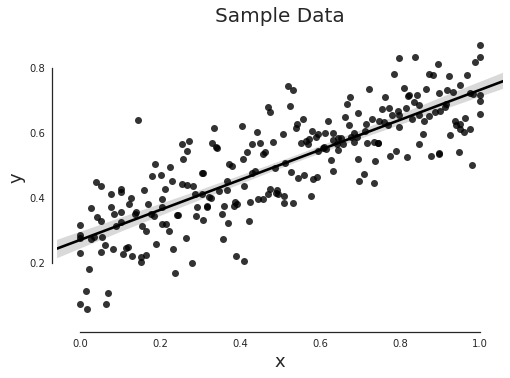

In [3]:
# Generate model data in n_bins

n_bins = 5
n_pts = [20, 40, 50, 60, 80]

# Obtain sample data and plot data and model fit

x = [] ; y = [] ; b = []

for bin in range(n_bins):
    x_i, y_i = randomizeModel(num = n_pts[bin])
    b_i = [bin] * n_pts[bin]
    
    x.extend(x_i)
    y.extend(y_i)
    b.extend(b_i)

# Make a dataframe to hold the data and associated bin (categorical)
df = pd.DataFrame({'x': x, 'y': y, 'b': b})

# Plot entire data.
ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=True, color='black', label="Data")
ax.set(title='Sample Data')
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Independent Bayesian Modeling

To begin, we will perform a standard Bayesian modeling of each separate data set, which is known as unpooled modeling. This approach is also not hierarchical as we do not fit each data set while also fitting the entire, pooled data set. While conceptually straightforward, an unpooled approach is unable to capitalize on the additional information provided by the entire data set when fitting each data subset. In this case, however, we perform the unpooled modeling to provide a comparison baseline for the pooled models we will compute next. 

In the following code cell, we perform the fitting for each data set by solely using the data in each respective bin. We make one change from the previous notebook example, in the we now model the prior for the `intercept` as a normal distribution.

-----

In [4]:
# This example follow the example in the pymc3 documentation
# http://pymc-devs.github.io/pymc3/GLM-hierarchical/
import pymc3 as pm

indiv_traces = {}

for bin in range(n_bins):

    # Select subset of data
    b_df = df.ix[df.b == bin]
    b_x = b_df.x
    b_y = b_df.y
    
    print('\n\nComputing Posterior for bin {0}'.format(bin))

    with pm.Model() as bin_model:
    
        # First, define stochastic model variables
        intercept = pm.Normal('Intercept', mu = 0.25, sd = 1.0)
        slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
        # Now define stochastic variable for observation errors.    
        sigma = pm.Normal('sigma', mu = 1., sd = 2.0)

        # Expected values using original indepedent variables
        # Deterministic Variable
        b_y_exp =  intercept + slope * b_x

        # Sample values (likelihood)
        likelihood = pm.Normal('yn', mu=b_y_exp, sd=sigma, observed=b_y)
        
        # Compute starting point, define sampler, 
        # and generate traces from the likelihood
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace = pm.sample(n_samples, step=step, start=start)
    
    # keep trace for later analysis
    indiv_traces[bin] = trace



Computing Posterior for bin 0
Optimization terminated successfully.
         Current function value: -15.500589
         Iterations: 14
         Function evaluations: 34
         Gradient evaluations: 27


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 5000/5000 [00:09<00:00, 536.21it/s]




Computing Posterior for bin 1
Optimization terminated successfully.
         Current function value: -38.884128
         Iterations: 14
         Function evaluations: 39
         Gradient evaluations: 31


100%|██████████| 5000/5000 [00:09<00:00, 555.51it/s]




Computing Posterior for bin 2
Optimization terminated successfully.
         Current function value: -38.539769
         Iterations: 14
         Function evaluations: 38
         Gradient evaluations: 31


100%|██████████| 5000/5000 [00:08<00:00, 564.84it/s]




Computing Posterior for bin 3
Optimization terminated successfully.
         Current function value: -51.275370
         Iterations: 15
         Function evaluations: 38
         Gradient evaluations: 30


100%|██████████| 5000/5000 [00:09<00:00, 540.27it/s]




Computing Posterior for bin 4
Optimization terminated successfully.
         Current function value: -73.269267
         Iterations: 14
         Function evaluations: 36
         Gradient evaluations: 28


100%|██████████| 5000/5000 [00:08<00:00, 565.29it/s]


-----

[[Back to TOC]](#Table-of-Contents)

## Hierarchical Modeling

Next, we apply Bayesian hierarchical modeling, where we fit the entire data set, while also modeling each data subset. To do this, we first define the parameters for the individual data, which we now do by using stochastic variables: `mui_i` and `sigmai_i` for the end points of the normal distribution for the `intercept` value, and `mus_i` and `sigmas_i` for the normal distribution for the `slope` value. In addition, we specify that there should be `n_bins` different `slope` and `intercept` prior values generated, one for each independent data set.

Otherwise, the modeling proceeds as before, except our expected and observed values for the dependent variable (`y`) are binned quantities, where the bin value is a categorical column in the DataFrame.

-----

In [5]:
b_idx = df['b'].values

with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mui_i = pm.Normal('mui_i', mu=0.0, sd=0.5**2)
    sigmai_i = pm.Uniform('sigmai_i', lower=0.0, upper=1.0)
  
    mus_i = pm.Normal('mus_i', mu=0.0, sd=0.5**2)
    sigmas_i = pm.Uniform('sigmas_i', lower=0.0, upper=1.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).

    intercept = pm.Normal('Intercept', mu = mui_i, sd = sigmai_i, shape=n_bins)
    slope = pm.Normal('Slope', mu = mus_i, sd = sigmas_i, shape=n_bins)

    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('Sigma', mu = 1., sd = 2.0)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept[b_idx] + slope[b_idx] * df.x

    # Sample values (likelihood)
    likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=df.y)

In [6]:
# Compute the hierarhical model likelihood and generate sample points.
with hierarchical_model:
    hierarchical_trace = pm.sample(n_samples, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 205.17: 100%|██████████| 200000/200000 [00:38<00:00, 5132.62it/s]
Finished [100%]: Average ELBO = 205.16
100%|██████████| 5000/5000 [01:09<00:00, 72.41it/s] 


-----

[[Back to TOC]](#Table-of-Contents)

### Analyze Hierarchical Results

We can analyze the model parameters as before, however, the trace values are now tagged with the bin value to which they belong. As a result, when we analyze the traces, we obtain bin-dependent trace statistics. As expected, the precision of a statistical summary of the trace becomes better with increasing number of data points (i.e., higher bin number in our example). 

-----

In [7]:
pm.summary(hierarchical_trace[-n_burn:],
           varnames=['Slope', 'Intercept', 'Sigma', 'mui_i', 'sigmai_i', 'mus_i', 'sigmas_i'])


Slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.453            0.033            0.001            [0.392, 0.521]
  0.464            0.028            0.001            [0.411, 0.523]
  0.451            0.030            0.001            [0.384, 0.504]
  0.465            0.026            0.001            [0.418, 0.520]
  0.468            0.026            0.001            [0.420, 0.518]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.383          0.434          0.454          0.474          0.515
  0.409          0.447          0.463          0.481          0.521
  0.385          0.434          0.453          0.470          0.506
  0.415          0.448          0.464          0.482          0.519
  0.422          0.450          0.467          0.485          0.520


Intercep

-----

[[Back to TOC]](#Table-of-Contents)

### Visualize Hierarchical Results

Likewise, we can visualize the traces as before, but we now see the bin-dependent traces for the model parameters. If one really wishes to explore the traces or the distribution of the trace values, it will likely be necessary to visualize them directly as done in the Bayesian modeling notebook.

-----

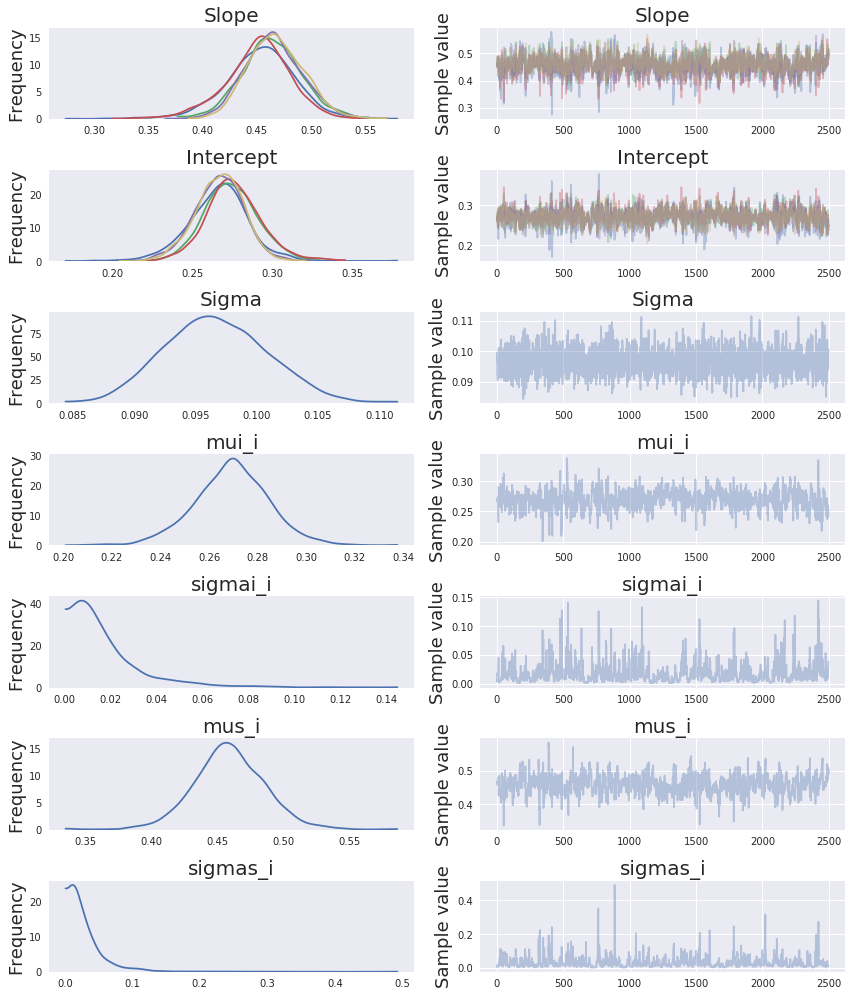

In [8]:
sns.set_style('darkgrid')
_ = pm.traceplot(hierarchical_trace[-n_burn:],
             varnames=['Slope', 'Intercept', 'Sigma', 'mui_i', 'sigmai_i', 'mus_i', 'sigmas_i'])

-----

[[Back to TOC]](#Table-of-Contents)

## Method Comparison

We can compare the model predictions for the unpooled and pooled model fits by computing the statistical characterizations of each model from their respective traces and over-plotting the data, true model, and the individual and hierarchical model fits. We first define a helper function to plot model fits given the data and traces, before plotting the results for four of the five bins in our data set.

-----

In [9]:
# Helper function for plotting data, and model fit regressions
def makePlot(axs, df, i_traces, h_traces, c_bin):
    # Grab the bin data
    c_trace = i_traces[c_bin]

    # plot the data for current bin
    sns.regplot(data = df.ix[df.b == c_bin], x = 'x', y = 'y', ax=axs,
                fit_reg=False, color='black', label="Data")

    # Compute and plot the true relationship
    x_sample = np.linspace(-0.1, 1.1, 100)
    y_sample = theModel(x_sample)
    axs.plot(x_sample, y_sample, color='r', lw=3, alpha = 0.75,
             label='True Regression')

    # Define the mean, hiearchical posterior parameters for current bin
    params = {}
    params['Intercept'] = np.mean(h_traces['Intercept'][-n_burn:, c_bin]) 
    params['Slope'] = np.mean(h_traces['Slope'][-n_burn:, c_bin])

    # Compute and plot the mean, hiearchical posterior prediction
    y_est = theModel(x_sample, params)
    axs.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75,
             label='Hiearchical Posterior Regression')

    # Define the mean, unpooled posterior parameters for the current bin
    params = {}
    params['Intercept'] = np.mean(c_trace['Intercept'][-n_burn:]) 
    params['Slope'] = np.mean(c_trace['Slope'][-n_burn:])

    # Compute and plot the mean, unpooled posterior prediction
    y_est = theModel(x_sample, params)
    axs.plot(x_sample, y_est, color='g', lw=3, alpha = 0.75,
             label='Unpooled Posterior Regression')
    
    # Decorate plot
    axs.set(title=f'Bin {c_bin} Posterior Predictions', 
            xlabel='x', ylabel='y',
            xlim=(-0.2, 1.2), ylim=(-0.2, 1.2))

    lgnd = axs.legend(loc='upper left')
    
    for lg in lgnd.legendHandles:
        lg.set_linewidth(2.0)
        
    # Clean-up
    sns.despine(offset = 5, trim=True)

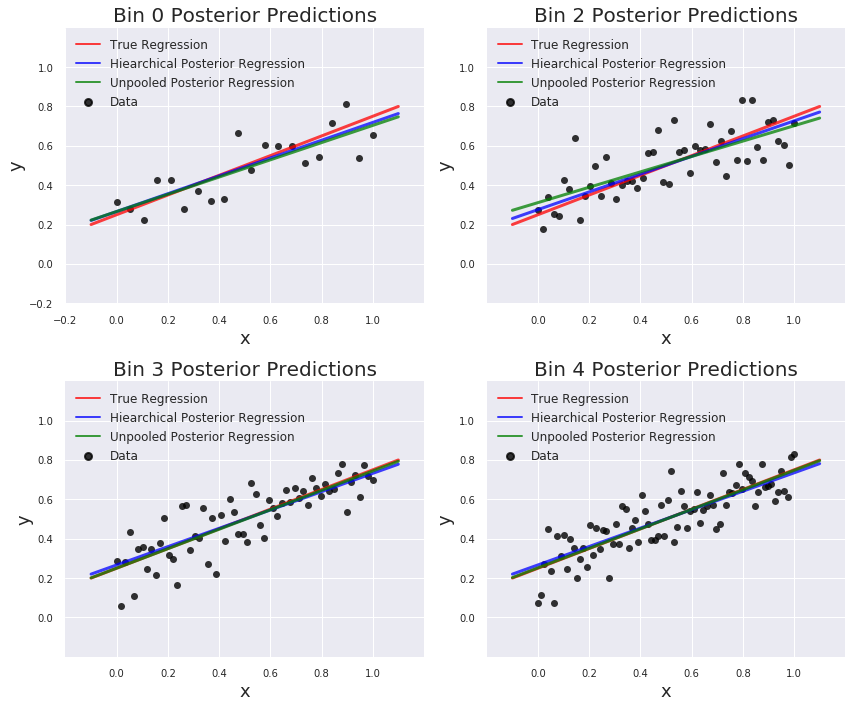

In [10]:
# Plot four bins
fig, axs = plt.subplots(figsize=(12, 10), nrows=2, ncols=2)

makePlot(axs[0][0], df, indiv_traces, hierarchical_trace, 0)
makePlot(axs[0][1], df, indiv_traces, hierarchical_trace, 2)
makePlot(axs[1][0], df, indiv_traces, hierarchical_trace, 3)
makePlot(axs[1][1], df, indiv_traces, hierarchical_trace, 4)

plt.tight_layout()

-----

[[Back to TOC]](#Table-of-Contents)

## Hierarchical Modeling Effects

We can also examine how the effect of performing a hierarchical model affected the modeling of the individual data sets. To do this, we compute the parameter values for each binned data set, and plotting the change in the location of each posterior sample point. In this manner, we can see the effect of pooling the data, which tends to pull the individual fits toward the global fit (indicated in the plot by the black plus sign). Also, notice how far the parameter values for the different bins move, which is related to the number of points in each bin.

-----

In [11]:
# Make Shrinkage Plot

# Compute mean quantities for plot
hier_i = hierarchical_trace['Intercept'][-n_burn:].mean(axis=0)
hier_s = hierarchical_trace['Slope'][-n_burn:].mean(axis=0)
indv_i = [indiv_traces[b]['Intercept'][-n_burn:].mean() for b in range(n_bins)]
indv_s = [indiv_traces[b]['Slope'][-n_burn:].mean() for b in range(n_bins)]

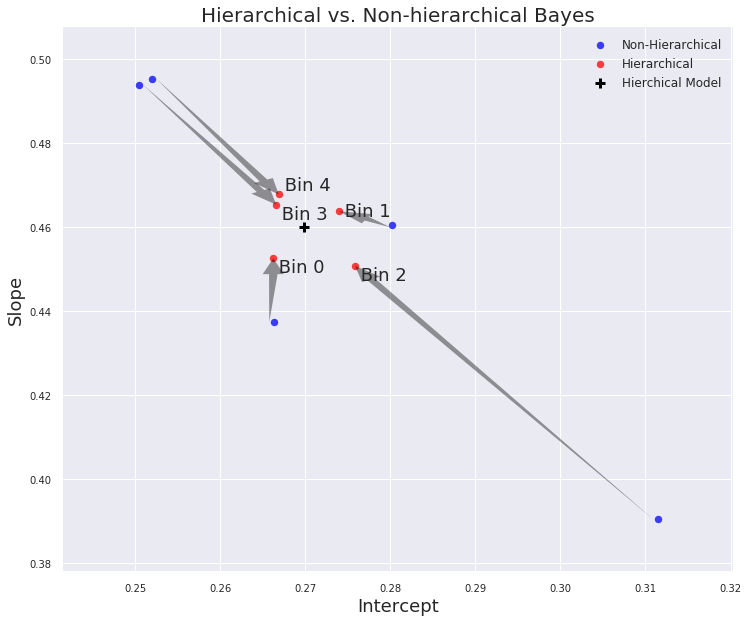

In [12]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# plot individual and hierarchical model sample parameter values.
ax.scatter(indv_i, indv_s, c='b', s=50, alpha=0.75, label = 'Non-Hierarchical')
ax.scatter(hier_i, hier_s, c='r', s=50, alpha=0.75, label = 'Hierarchical')

# Plot arrows linking individual to hierarchical
vlocs = ['top', 'center', 'top', 'top', 'bottom']
for i in range(len(indv_s)):  
    ax.arrow(indv_i[i], indv_s[i], hier_i[i] - indv_i[i], hier_s[i] - indv_s[i], 
             fc="k", ec="k", length_includes_head=True, 
             alpha=0.4, head_width=.0025, lw =0.001)
    ax.text(hier_i[i], hier_s[i], ' Bin {0}'.format(i), 
            size = 18, ha='left', va=vlocs[i])


# Plot Full hierarchical model sample parameters
xh = hierarchical_trace['Intercept'][-n_burn:].mean()
yh = hierarchical_trace['Slope'][-n_burn:].mean()
ax.scatter(xh, yh, c='k', s=100, marker='+', alpha = 1, lw=3, label='Hierchical Model')

# Decorate plot
ax.set(title='Hierarchical vs. Non-hierarchical Bayes', 
       xlabel='Intercept', ylabel='Slope')

lgnd = ax.legend(loc=0)

# Clean-up
sns.despine(offset = 5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we introduced Bayesian hierarchical modeling. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the model parameters, rerun the notebook and see how the different (unpooled versus pooled) modeling approaches perform.
2. Change the number of points in each bin, rerun the notebook and see how the different (unpooled versus pooled) modeling approaches perform.
3. Change the model for the prior distributions, e.g., try a uniform distribution for the intercept. How do the different (unpooled versus pooled) modeling approaches perform?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Wikipedia article on [multi-level models][wmlm]
3. Chapter two on [using PyMC3][bmh2] from _Bayesian Method for Hackers_ by Cam Davidson Pilon
45. Notebook on [hierarchical models][ihm]
32. Notebook on [Bayesian hierarchical modeling][bmps3]

-----
[wmlm]: https://en.wikipedia.org/wiki/Multilevel_model

[bmps3]: http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%203.%20Hierarchical%20modelling.ipynb

[bbabt]: http://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/

[ihm]: https://pymc-devs.github.io/pymc3/notebooks/GLM-hierarchical.html

[bpabt]: http://chris-said.io/2016/02/28/four-pitfalls-of-hill-climbing/
[bmh2]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode